# Part I: Preprocessing

## Basic settings

In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import os
import sys
import warnings
from datetime import datetime, timedelta

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 50
pd.options.display.max_columns = None

In [126]:
src_path = os.path.abspath(os.path.join("../..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

In [127]:
from data_generator.data_generator import check_missing_values
from utils.plots import plot_sales
from utils.utils import correct_outliers, fill_missing_values,fill_missing_values_grouped, get_sample_stores, analyze_product_distribution

In [128]:
DATA_DIR = "../../data"

## Load and clean data

In [129]:
# Load datasets
df_sales_train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
df_sales_test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
df_weather = pd.read_csv(os.path.join(DATA_DIR, "weather.csv"))
df_key = pd.read_csv(os.path.join(DATA_DIR, "key.csv"))

In [130]:
# Combine sales data
df_sales = pd.concat([df_sales_train], ignore_index=True)
df_sales = df_sales.sort_values(['store_nbr', 'item_nbr', 'date'])

# Convert date columns to datetime
df_sales["date"] = pd.to_datetime(df_sales["date"])
df_weather["date"] = pd.to_datetime(df_weather["date"])

### Handling missing values

In [131]:
# Check missing values for weather data
display(check_missing_values(df_weather))

,counts,ratio (%)
station_nbr,0,0.0
date,0,0.0
tmax,0,0.0
tmin,0,0.0
tavg,0,0.0
depart,0,0.0
dewpoint,0,0.0
wetbulb,0,0.0
heat,0,0.0
cool,0,0.0


In [132]:
# Check missing values for sales data
display(check_missing_values(df_sales))

,counts,ratio (%)
date,0,0.0
store_nbr,0,0.0
item_nbr,0,0.0
units,0,0.0


###  Data Filtering: Remove Non-Selling Products
This step identifies and filters out store-item combinations with zero total sales. 
Not all stores carry all products, keeping zero-sale combinations introduces noise 
and reduces model accuracy.

**Approach:**
- Calculate total sales per store-item pair
- Create whitelist of valid combinations (total sales > 0)
- Apply inner join to retain only valid pairs

**Expected outcome:** Reduced dataset size while maintaining all meaningful sales data.


🔍 ANALYZING PRODUCT DISTRIBUTION...

✅ Found 255 valid (Store, Item) pairs with sales > 0


TOP 15 MOST WIDELY SOLD PRODUCTS
 item_nbr  num_stores
       93          29
        5          18
        9          17
       45          16
       16           8
       86           7
      105           6
       37           6
       15           5
       44           5
       50           5
       68           5
      104           4
       51           4
       61           3



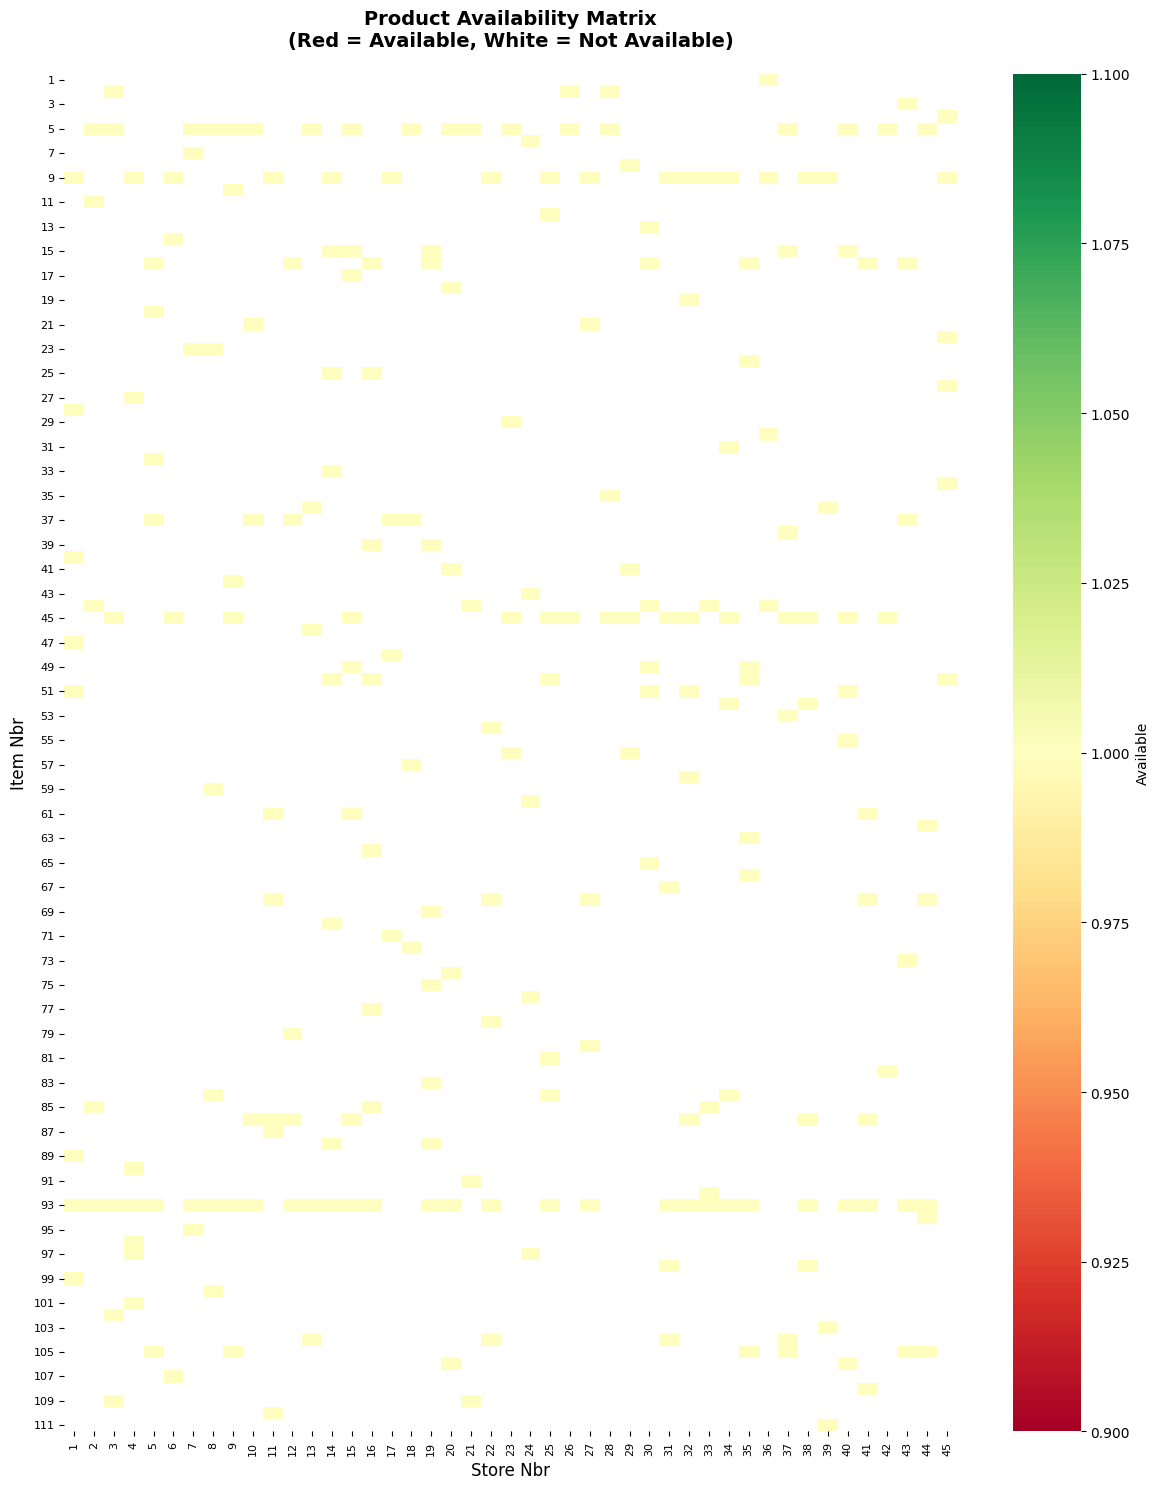


SUMMARY: Product Distribution Analysis
Total Stores: 45
Total Items: 111
Total Possible Combinations: 4,995
Actual Products Sold: 255
Coverage: 5.1%

Original rows: 4,617,600
Filtered rows: 236,038
Reduction: 94.9%


In [133]:
# Analyze product distribution across stores
retailed_items = analyze_product_distribution(
    df=df_sales,
    store_col='store_nbr',
    item_col='item_nbr',
    value_col='units',
    show_heatmap=True,
    show_top=True,
    top_n=15
)

# Filter dataset: Keep only store-item pairs with sales > 0
# Inner join retains rows present in BOTH dataframes
df_retailed = df_sales.merge(
    retailed_items, 
    on=['store_nbr', 'item_nbr'], 
    how='inner'
)
df_retailed['logunits'] = np.log1p(df_retailed['units'])

print(f"Original rows: {len(df_sales):,}")
print(f"Filtered rows: {len(df_retailed):,}")
print(f"Reduction: {(1 - len(df_retailed)/len(df_sales))*100:.1f}%")

Con số 5.1% nói lên điều gì?
Nó nói rằng: Trung bình, một cửa hàng chỉ bán khoảng 5-6 món hàng trong danh sách 111 món kia thôi

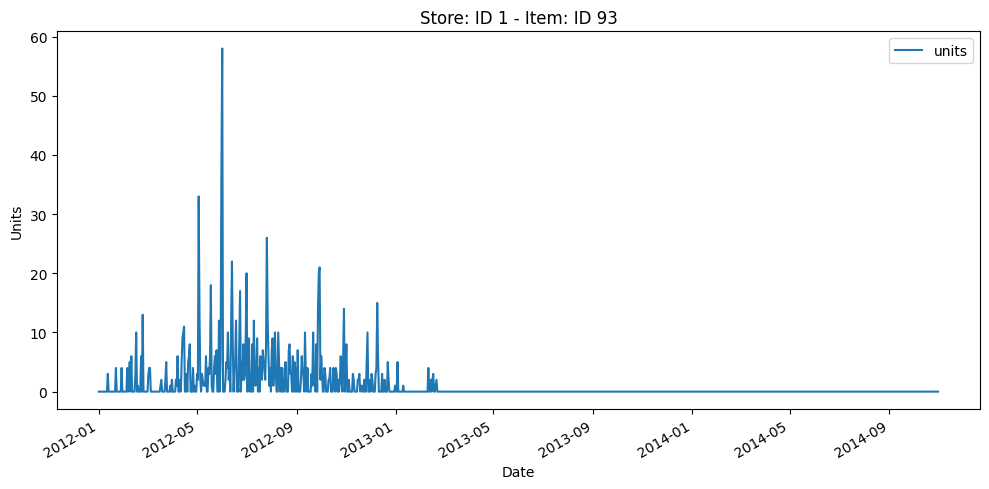

In [134]:
# Checking nan values and outliers in a plot
plot_sales(df_retailed, store_id=1, item_id=93)

In [135]:
# Fill nan using mean values
df_retailed_filled = fill_missing_values_grouped(df_retailed)

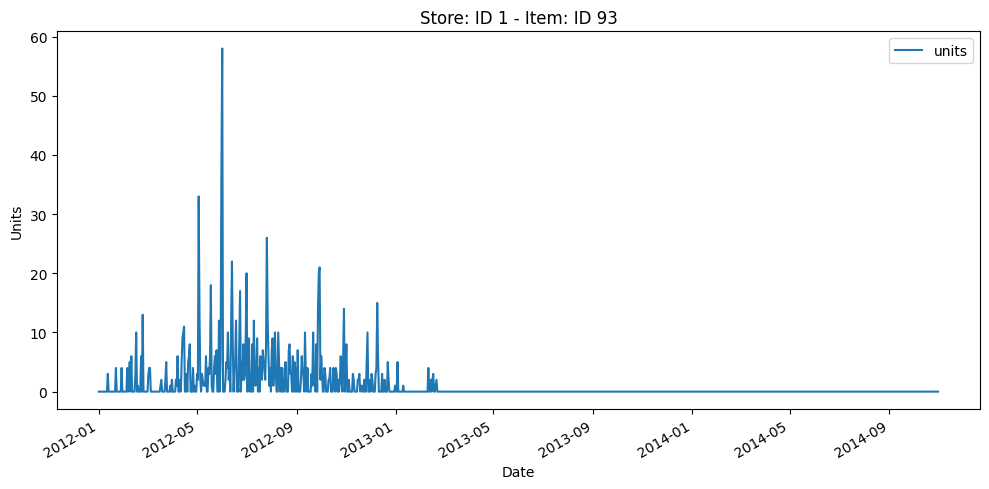

In [136]:
# Checking nan values and outliers in a plot
plot_sales(df_retailed_filled, store_id=1, item_id=93)

In [137]:
# Check missing values
display(check_missing_values(df_retailed_filled))

,counts,ratio (%)
date,0,0.0
store_nbr,0,0.0
item_nbr,0,0.0
units,0,0.0
logunits,0,0.0


### Check and correct outliers

In [138]:
df_retailed_filled

,date,store_nbr,item_nbr,units,logunits
0,2012-01-01,1,9,29,3.401197
1,2012-01-02,1,9,60,4.110874
2,2012-01-03,1,9,15,2.772589
3,2012-01-04,1,9,20,3.044522
4,2012-01-05,1,9,16,2.833213
...,...,...,...,...,...
236033,2014-10-27,45,50,0,0.000000
236034,2014-10-28,45,50,1,0.693147
236035,2014-10-29,45,50,0,0.000000
236036,2014-10-30,45,50,0,0.000000


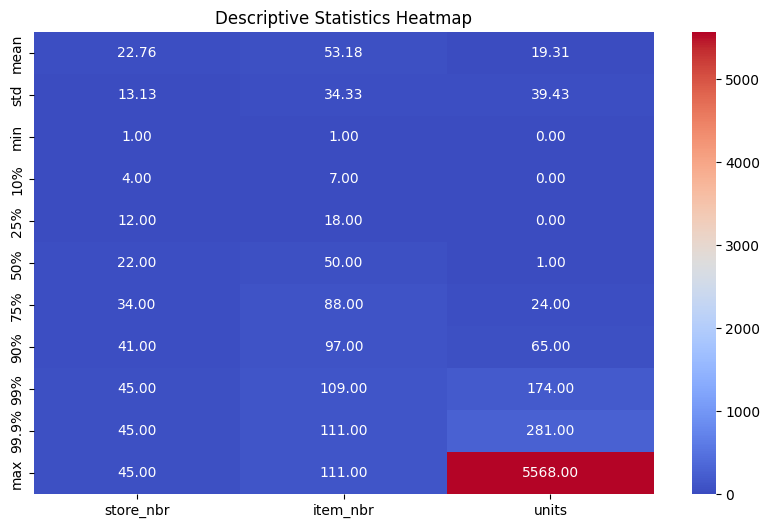

In [139]:
# Using heat map to visualize outliers
summary = (
    df_retailed_filled[["store_nbr", "item_nbr", "units"]] 
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
    .iloc[1:]
)

plt.figure(figsize=(10, 6))
sns.heatmap(summary, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Descriptive Statistics Heatmap")
plt.show()

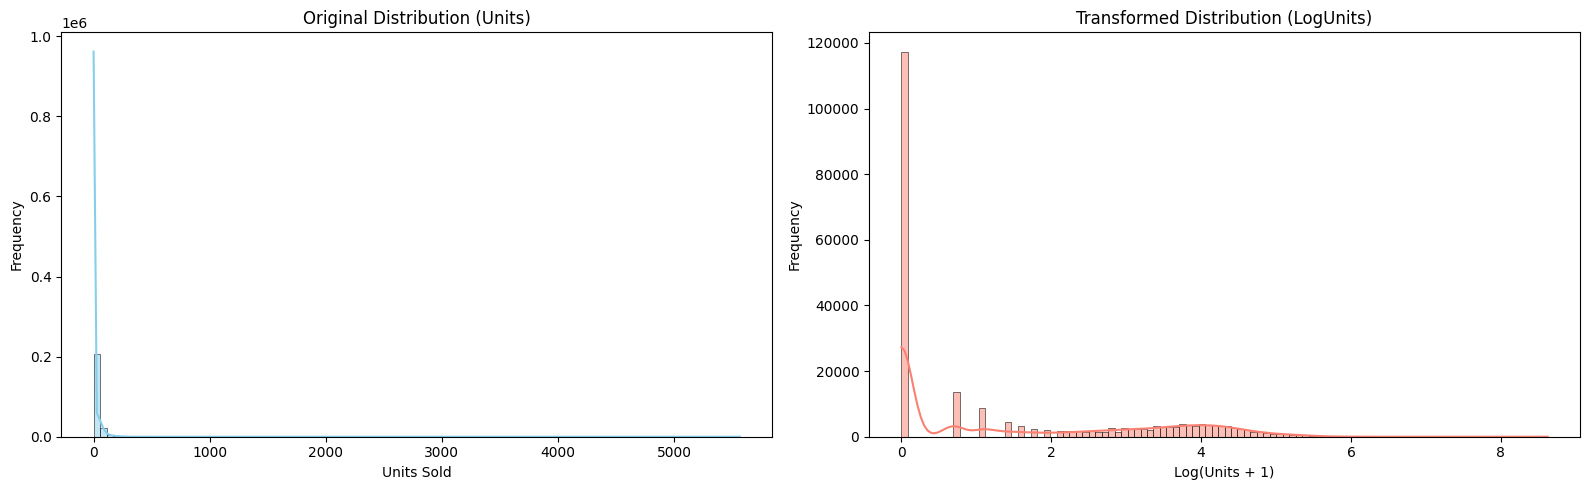

In [140]:
# --- SO SÁNH TRỰC QUAN: TRƯỚC VÀ SAU KHI LOG ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Biểu đồ gốc (Units) - Bị lệch trái, đuôi dài
sns.histplot(df_retailed_filled["units"], bins=100, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Original Distribution (Units)")
axes[0].set_xlabel("Units Sold")
axes[0].set_ylabel("Frequency")

# 2. Biểu đồ Log (LogUnits) - Phân phối chuẩn đẹp hơn
sns.histplot(df_retailed_filled["logunits"], bins=100, kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Transformed Distribution (LogUnits)")
axes[1].set_xlabel("Log(Units + 1)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [141]:
# Correct outliers
df_sales_corrected = correct_outliers(df=df_retailed_filled)

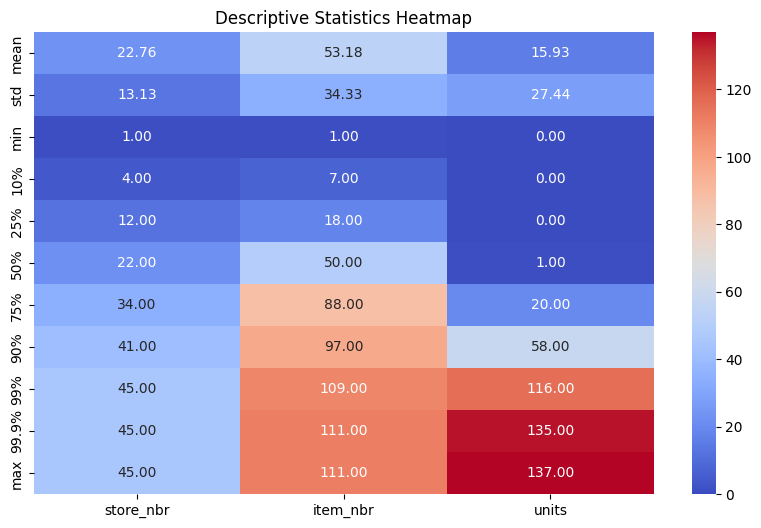

In [142]:
# Check if outliers were corrected properly
summary = (
    df_sales_corrected[["store_nbr", "item_nbr", "units"]] 
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
    .iloc[1:]
)

plt.figure(figsize=(10, 6))
sns.heatmap(summary, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Descriptive Statistics Heatmap")
plt.show()

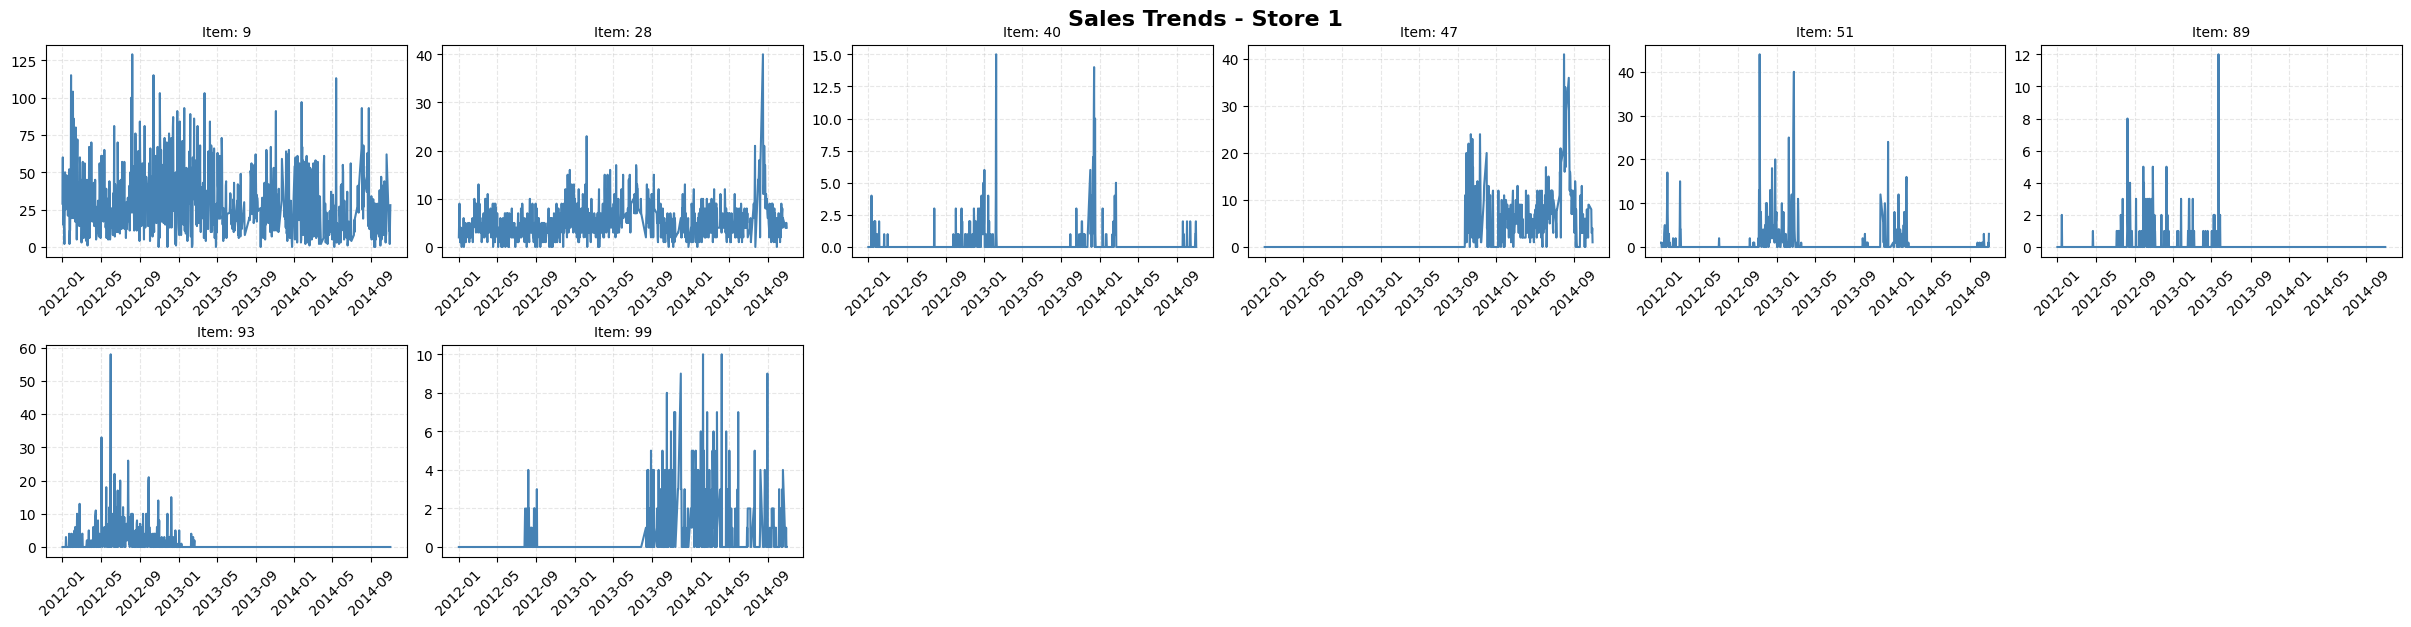

In [143]:
import math

# 1. Lấy dữ liệu Store mục tiêu
store_nbr = 1
# Filter trực tiếp thay vì gọi hàm get_sample_stores (để code ngắn gọn hơn)
df_sample_store = df_sales_corrected[df_sales_corrected["store_nbr"] == store_nbr]

# 2. Lấy danh sách Items (chỉ những item có trong dataset đã filter)
lst_items = df_sample_store["item_nbr"].unique().tolist()

# 3. Tính toán Layout Grid động (Clean Code)
ncols = 6
nrows = math.ceil(len(lst_items) / ncols)

fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 4, nrows * 3), constrained_layout=True
)
axes = axes.flatten()

# 4. Vẽ biểu đồ
for idx, item_nbr in enumerate(lst_items):
    ax = axes[idx]
    df2plot = df_sample_store[df_sample_store["item_nbr"] == item_nbr]
    
    # Vẽ đường sales (units)
    ax.plot(df2plot["date"], df2plot["units"], color="steelblue", linewidth=1.5)
    
    ax.set_title(f"Item: {item_nbr}", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True, linestyle="--", alpha=0.3)

# 5. Ẩn các subplots thừa
for ax in axes[len(lst_items):]:
    ax.axis("off")

# Main title
fig.suptitle(f"Sales Trends - Store {store_nbr}", fontsize=16, fontweight="bold", y=1.02)
plt.show()


In [144]:
check_missing_values(df_sales_corrected)

,counts,ratio (%)
date,0,0.0
store_nbr,0,0.0
item_nbr,0,0.0
units,0,0.0
logunits,0,0.0


### Weather data

In [145]:
# Convert city in weather to province to match with sales data
# Since the cities and provinces have the same names in our dataset
df_weather = df_weather.rename(columns={"city": "province"})

# Create a mapping between date and province to weather attributes
weather_mapping = df_weather.set_index(["date", "province"])
weather_mapping

KeyError: "None of ['province'] are in the columns"

## Save preprocessed data

In [ ]:
# Saving sales data
sales_data_path = os.path.join(DATA_DIR, "sales_data_preprocessed.csv")
print(f"Saving sales data to :{sales_data_path}")
df_sales_corrected.to_csv(sales_data_path, index=False)

# Saving weather data
weather_data_path = os.path.join(DATA_DIR, "weather_preprocessed.csv")
print(f"Saving weather data to :{weather_data_path}")
df_weather.to_csv(weather_data_path, index=False)

Saving sales data to :../data/sales_data_preprocessed.csv
Saving weather data to :../data/weather_preprocessed.csv
